In [1]:
"""
This is a template for the Physics-Informed Convolution-AutoEncoder (PICAE)
estimator. The algorithm enforces conservaiton of mass; built with PyTorch.

Note: example data is randomly sampled from a normal distribution, 
      hence the results won't be valid.
      
-pikarpov      
"""

%matplotlib inline
import os
import sys

sys.path.append("../../")

from sapsan.lib.backends import MLflowBackend, FakeBackend
from sapsan.lib.data import HDF5Dataset, EquidistantSampling, flatten
from sapsan.lib.estimator.picae.picae_estimator import PICAE, PICAEConfig
from sapsan.lib import Train, Evaluate

In [2]:
#--- Experiment tracking backend ---
#MLflow - the server will be launched automatically
#in case it won't, type in cmd: mlflow ui --port=5000
#uncomment tracking_backend to use mlflow

experiment_name = "PICAE experiment"
tracking_backend = FakeBackend()
#tracking_backend = MLflowBackend(experiment_name, host="localhost", port=5000)

In [3]:
#--- Data setup ---
#In the intereset of loading and training multiple timesteps
#one can specify which checkpoints to use and where
#they appear in the path via syntax: {checkpoint:format}
#
#Next, you need to specify which features to load; let's assume 
#        path = "{feature}.h5"
#
# 1) If in different files, then specify features directly;
#    The default HDF5 label will be the last label in the file
#    Ex: features = ['velocity', 'denisty', 'pressure']
# 2) If in the same, then duplicate the name in features
#    and specify which labels to pull
#    Ex: features = ["data", "data", "data"]
#        feature_labels = ['velocity', 'density', 'pressure']

path = "data/picae/t{checkpoint:1.0f}/picae_random_{feature}.h5"
features = ['u']
target = ['u']

#Dimensionality of your data in format [D,H,W]
INPUT_SIZE = [32,32,32]

#Reduce dimensionality to the following in format [D,H,W]
SAMPLE_TO = [16,16,16]

#Sampler to use for reduction
sampler = EquidistantSampling(SAMPLE_TO)

In [4]:
#Load the data
data_loader = HDF5Dataset(path = path,
                          features = features,
                          target = target,
                          checkpoints = [0],
                          input_size = INPUT_SIZE,
                          sampler = sampler)
x, y = data_loader.load_numpy()

loaders = data_loader.convert_to_torch([x,y])

Features:  ['u']
Fetures_label: ['None']
Loading 'random' from file 'data/picae/t0/picae_random_u.h5'
----------
Sampling the input data of size (32, 32, 32) into size [16, 16, 16]
Loading 'random' from file 'data/picae/t0/picae_random_u.h5'
----------
Sampling the input data of size (32, 32, 32) into size [16, 16, 16]
Train data shapes:  (1, 3, 16, 16, 16) (1, 3, 16, 16, 16)
Valid data shapes:  (1, 3, 16, 16, 16) (1, 3, 16, 16, 16)


/home/pkarpov/Sapsan/sapsan/examples/../../sapsan/lib/data/hdf5_dataset.py:190: UserWarning: batch_size != sampled_size. Setting the two equal.
  features_checkpoint_batch = self._get_input_data(checkpoint,


In [5]:
estimator = PICAE(config=PICAEConfig(nfilters = 6, 
                                     kernel_size = (3,3,3), 
                                     enc_nlayers = 3,                        
                                     dec_nlayers = 3, 
                                     n_epochs = 5,
                                     patience = 10, 
                                     min_delta = 1e-5),
                  loaders = loaders)

In [6]:
#Set the experiment
training_experiment = Train(model = estimator,
                            backend=tracking_backend,                 
                            data_parameters = data_loader)

#Train the model
estimator = training_experiment.run()


 ====== run info ======
 Device used:  cpu
 DDP:          False
 
train (1/5) loss: 1.0044862031936646 | loss/mean: 1.0044862031936646 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
valid (1/5) loss: 1.004463791847229 | loss/mean: 1.004463791847229 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (1/5) lr: 0.0001 | momentum: 0.9
train (2/5) loss: 1.004463791847229 | loss/mean: 1.004463791847229 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
valid (2/5) loss: 1.0044430494308472 | loss/mean: 1.0044430494308472 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (2/5) lr: 0.0001 | momentum: 0.9
train (3/5) loss: 1.0044430494308472 | loss/mean: 1.0044430494308472 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
valid (3/5) loss: 1.0044234991073608 | loss/mean: 1.0044234991073608 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (3/5) lr: 0.0001 | momentum: 0.9
train (4/5) loss: 1.0044234991073608 | loss/mean: 1.0044234991073608 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
valid (4/5) loss

Features:  ['u']
Fetures_label: ['None']
Loading 'random' from file 'data/picae/t0/picae_random_u.h5'
----------
Sampling the input data of size (32, 32, 32) into size [16, 16, 16]
Loading 'random' from file 'data/picae/t0/picae_random_u.h5'
----------
Sampling the input data of size (32, 32, 32) into size [16, 16, 16]
Train data shapes:  (1, 3, 16, 16, 16) (1, 3, 16, 16, 16)
Valid data shapes:  (1, 3, 16, 16, 16) (1, 3, 16, 16, 16)

 ====== run info ======
 Device used:  cpu
 DDP:          False
 


eval - runtime:  0.011397838592529297


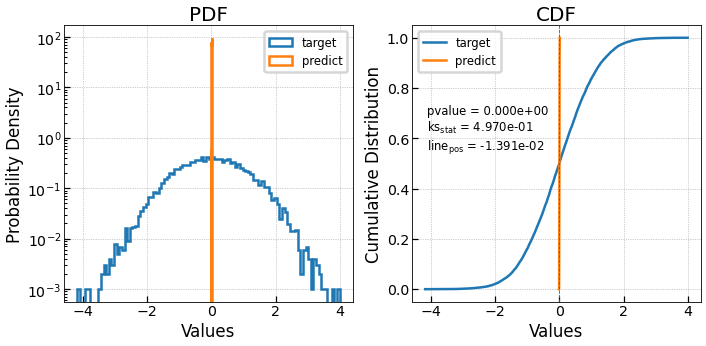

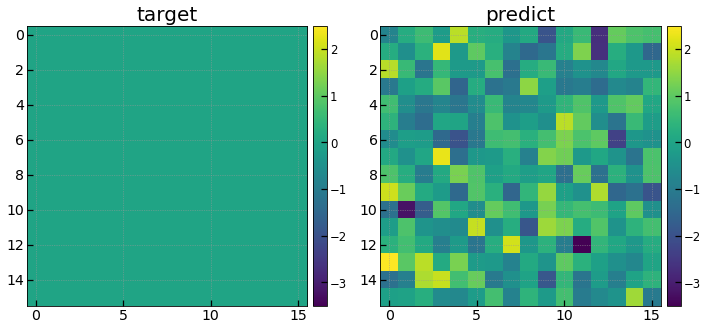

In [7]:
#--- Test the model ---
#Load the data
data_loader = HDF5Dataset(path = path,
                          features = features,
                          target = target,
                          checkpoints = [0],
                          input_size = INPUT_SIZE,
                          sampler = sampler)
x, y = data_loader.load_numpy()
loaders = data_loader.convert_to_torch([x,y])

#Set the test experiment
#loaders need to take in the same size data as the individual training batch
estimator.loaders = loaders
evaluation_experiment = Evaluate(model=estimator,
                                 backend=tracking_backend,
                                 data_parameters = data_loader)


#Test the model
#Evaluate() returns a dict, results = {'predict':np.ndarray, 'target':np.ndarray}
results = evaluation_experiment.run()